In [1]:
%matplotlib inline

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

## Build a baseline model of stellar mass

In [40]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog()

from halotools.empirical_models import Moster13SmHm
model = Moster13SmHm()

halocat.halo_table['stellar_mass'] = model.mc_stellar_mass(
    prim_haloprop=halocat.halo_table['halo_mpeak'], redshift=0)


## Define a simple model for $M_{\ast}-$dependence of ${\rm B/T}$ power law index

In [41]:
def powerlaw_index(log_mstar):
    abscissa = [9, 10, 11.5]
    ordinates = [3, 2, 1]
    return np.interp(log_mstar, abscissa, ordinates)

## Calculate the spin-percentile

In [42]:
from halotools.utils import sliding_conditional_percentile

x = halocat.halo_table['stellar_mass']
y = halocat.halo_table['halo_spin']
nwin = 201
halocat.halo_table['spin_percentile'] = sliding_conditional_percentile(x, y, nwin)

## Use CAM to generate a Monte Carlo realization of ${\rm B/T}$

In [43]:
a = powerlaw_index(np.log10(halocat.halo_table['stellar_mass']))
u = halocat.halo_table['spin_percentile']
halocat.halo_table['bulge_to_total_ratio'] = 1 - powerlaw.isf(1 - u, a)

### Plot the results

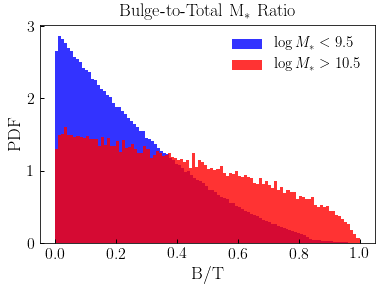

In [44]:
fig, ax = plt.subplots(1, 1)

mask1 = halocat.halo_table['stellar_mass'] < 10**9.5
mask2 = halocat.halo_table['stellar_mass'] > 10**10.5

__=ax.hist(halocat.halo_table['bulge_to_total_ratio'][mask1], 
           bins=100, alpha=0.8, normed=True, color='blue',
           label=r'$\log M_{\ast} < 9.5$')
__=ax.hist(halocat.halo_table['bulge_to_total_ratio'][mask2], 
           bins=100, alpha=0.8, normed=True, color='red',
           label=r'$\log M_{\ast} > 10.5$')

legend = ax.legend()

xlabel = ax.set_xlabel(r'${\rm B/T}$')
ylabel = ax.set_ylabel(r'${\rm PDF}$')
title = ax.set_title(r'${\rm Bulge}$-${\rm to}$-${\rm Total\ M_{\ast}\ Ratio}$')

figname = 'cam_example_bt_distributions.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

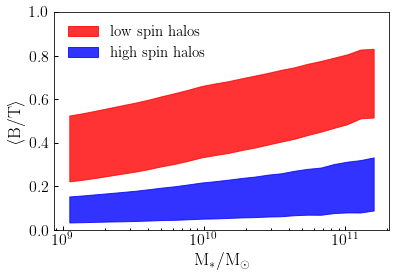

In [66]:
xmin, xmax = 9, 11.25

fig, ax = plt.subplots(1, 1)
xscale = ax.set_xscale('log')

from scipy.stats import binned_statistic
log_mass_bins = np.linspace(xmin, xmax, 25)
mass_mids = 10**(0.5*(log_mass_bins[:-1] + log_mass_bins[1:]))

median_bt, __, __ = binned_statistic(
    halocat.halo_table['stellar_mass'], halocat.halo_table['bulge_to_total_ratio'], 
    bins=10**log_mass_bins, statistic='median')
std_bt, __, __ = binned_statistic(
    halocat.halo_table['stellar_mass'], halocat.halo_table['bulge_to_total_ratio'], 
    bins=10**log_mass_bins, statistic=np.std)

low_spin_mask = halocat.halo_table['spin_percentile'] < 0.5
median_bt_low_spin, __, __ = binned_statistic(
    halocat.halo_table['stellar_mass'][low_spin_mask], 
    halocat.halo_table['bulge_to_total_ratio'][low_spin_mask], 
    bins=10**log_mass_bins, statistic='median')
std_bt_low_spin, __, __ = binned_statistic(
    halocat.halo_table['stellar_mass'][low_spin_mask], 
    halocat.halo_table['bulge_to_total_ratio'][low_spin_mask], 
    bins=10**log_mass_bins, statistic=np.std)

high_spin_mask = halocat.halo_table['spin_percentile'] > 0.5
median_bt_high_spin, __, __ = binned_statistic(
    halocat.halo_table['stellar_mass'][high_spin_mask], 
    halocat.halo_table['bulge_to_total_ratio'][high_spin_mask], 
    bins=10**log_mass_bins, statistic='median')
std_bt_high_spin, __, __ = binned_statistic(
    halocat.halo_table['stellar_mass'][high_spin_mask], 
    halocat.halo_table['bulge_to_total_ratio'][high_spin_mask], 
    bins=10**log_mass_bins, statistic=np.std)

y1 = median_bt_low_spin - std_bt_low_spin
y2 = median_bt_low_spin + std_bt_low_spin
__=ax.fill_between(mass_mids, y1, y2, alpha=0.8, color='red', 
                  label=r'${\rm low\ spin\ halos}$')

y1 = median_bt_high_spin - std_bt_high_spin
y2 = median_bt_high_spin + std_bt_high_spin
__=ax.fill_between(mass_mids, y1, y2, alpha=0.8, color='blue',
                  label=r'${\rm high\ spin\ halos}$')

ylim = ax.set_ylim(0, 1)

legend = ax.legend(loc='upper left')

xlabel = ax.set_xlabel(r'${\rm M_{\ast}/M_{\odot}}$')
ylabel = ax.set_ylabel(r'$\langle{\rm B/T}\rangle$')

figname = 'cam_example_bulge_disk_ratio.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')